# Generating Point Cloud from depth image
---
This notebook takes a depth and rgb image and converts it into a point cloud to display.

First thing to do is import all needed libraries

In [1]:
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import datetime

/Users/jornvandijck/Documents/HAMK/IctProject/HamkSmartBiomass/pointCloud/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Preparing the data
Next step is to define callibration data for the camera. This data is not perfect for our camera but it does the job for now.

Data is provided via the [NYU Depth Dataset](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html).

In [2]:
# Depth camera parameters:
FX_DEPTH = 5.8262448167737955e+02
FY_DEPTH = 5.8269103270988637e+02
CX_DEPTH = 3.1304475870804731e+02
CY_DEPTH = 2.3844389626620386e+02

# RGB camera parameters:
FX_RGB = 5.1885790117450188e+02
FY_RGB = 5.1946961112127485e+02
CX_RGB = 3.2558244941119034e+0
CY_RGB = 2.5373616633400465e+02

# Rotation matrix:
R = -np.array([[9.9997798940829263e-01, 5.0518419386157446e-03, 4.3011152014118693e-03],
                   [-5.0359919480810989e-03, 9.9998051861143999e-01, -3.6879781309514218e-03],
                   [- 4.3196624923060242e-03, 3.6662365748484798e-03, 9.9998394948385538e-01]])
# Translation vector:
T = np.array([2.5031875059141302e-02, -2.9342312935846411e-04, 6.6238747008330102e-04])


Reading the image is the next part. This takes the image in as a numpy array. After, we display some usefull data about the image array.

In [10]:
# Open the image and display basic information
depth_image = iio.imread("./images/png/depth/2023-11-09.16.22.35_depth_image.png")
rgb_image = iio.imread("./images/png/color/2023-11-08.20.31.23_color_image.png")

print(f"Image resolution: {depth_image.shape}")
print(f"Data type: {depth_image.dtype}")
print(f"Min value: {np.min(depth_image)}")
print(f"Max value: {np.max(depth_image)}")

Image resolution: (480, 848, 3)
Data type: uint8
Min value: 0
Max value: 254


Next up is calculating the grayscale image that we will need to generate the pointcloud. For development and debugging reasons, this will exported to a png file as well.

In [11]:
depth_grayscale = np.array(256 * depth_image / 0x0fff, dtype=np.uint8)
iio.imwrite(f"output/grayscale_{datetime.datetime.now().strftime('%Y%m%d_%H:%M:%S.%f')[:-3]}.png", depth_grayscale)

This cell is purely go show the depth image and the rgb image next to each other. This is an easy way to quickly check if the correct images are used.

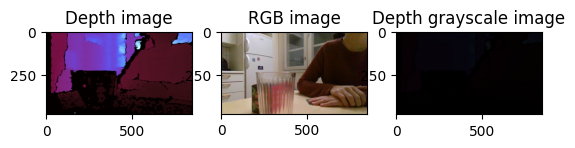

In [12]:
# Display depth and grayscale image:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(depth_image, cmap="gray")
axs[0].set_title('Depth image')
axs[1].imshow(rgb_image)
axs[1].set_title('RGB image')
axs[2].imshow(depth_grayscale, cmap="gray")
axs[2].set_title('Depth grayscale image')
plt.show()

### Generating the point cloud
Only two things left: generating the point cloud point coordinates and displaying the point cloud. The next cell does the first thing. It takes into account the callibration data defined earlier.

In [13]:
height, width, index = depth_image.shape

colors = []
pcd = []
for i in range(height):
    for j in range(width):
        """
            Convert the pixel from depth coordinate system
            to depth sensor 3D coordinate system
        """
        z = depth_image[i][j]
        x = (j - CX_DEPTH) * z / FX_DEPTH
        y = (i - CY_DEPTH) * z / FY_DEPTH

        """
            Convert the point from depth sensor 3D coordinate system
            to rgb camera coordinate system:
        """
        [x_RGB, y_RGB, z_RGB] = np.linalg.inv(R).dot([x, y, z]) - np.linalg.inv(R).dot(T)

        """
            Convert from rgb camera coordinates system
            to rgb image coordinates system:
        """
        j_rgb = int((x_RGB[0] * FX_RGB) / z_RGB[0] + CX_RGB + width / 2)
        i_rgb = int((y_RGB[0] * FY_RGB) / z_RGB[0] + CY_RGB)

        # Add point to point cloud:
        pcd.append([x[0], y[0], z[0]])

        # Add the color of the pixel if it exists:
        if 0 <= j_rgb < width and 0 <= i_rgb < height:
            colors.append(rgb_image[i_rgb][j_rgb] / 255)
        else:
            colors.append([0., 0., 0.])

Last step: Generate and show the point cloud itself. This cell converts the array of point coordinates to a 3d vector type. This is drawn and visualised with the open3d module.

In [14]:
pcd_o3d = o3d.geometry.PointCloud()  # create point cloud object
pcd_o3d.points = o3d.utility.Vector3dVector(pcd)  # set pcd_np as the point cloud points
pcd_o3d.colors = o3d.utility.Vector3dVector(colors)

### Saving the point cloud

In the last steps, all the data got calculated and the point was generated. In this extra part, the point cloud can be either saved or displayed.  
First displaying the point cloud:

In [1]:
o3d.visualization.draw_geometries([pcd_o3d])

NameError: name 'o3d' is not defined

Now, saving the point cloud as a ply file.

In [16]:
o3d.io.write_point_cloud("output/pointcloud.ply", pcd_o3d)

True